In [1]:
%matplotlib inline

In [2]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck')

from halotools.utils import SampleSelector

hosts, subs = SampleSelector.host_halo_selection(table=halocat.halo_table, return_subhalos=True)

In [3]:
log10_msub_min = 11
subhalo_mpeak_cut = 10**log10_msub_min

log10_mhost_min = max(11.75, log10_msub_min)
log10_mhost_max = 14.75

subhalo_sample_mask = subs['halo_mpeak'] > subhalo_mpeak_cut
subhalo_sample_mask *= subs['halo_mvir_host_halo'] > 10**log10_mhost_min
host_halo_sample_mask = hosts['halo_mvir'] > 10**log10_mhost_min

num_mhost_bins = 25
haloprop_bins = np.logspace(log10_mhost_min, log10_mhost_max, num_mhost_bins)
log10_bin_mids = 0.5*(np.log10(haloprop_bins[:-1]) + np.log10(haloprop_bins[1:]))
bin_mids = 10**log10_bin_mids

from halotools.mock_observables import hod_from_mock

mean_occupation_bolshoi, bin_edges = hod_from_mock(subs['halo_mvir_host_halo'][subhalo_sample_mask], 
                                           hosts['halo_mvir'][host_halo_sample_mask], 
                                                   haloprop_bins)
host_halo_counts = np.histogram(hosts['halo_mvir'][host_halo_sample_mask], 
                                bins=haloprop_bins)[0].astype('f4')

In [4]:
from jiang_usmf import monte_carlo_subhalo_population

def mean_nsub_prediction(beta, zeta, gamma1, alpha1, gamma2, alpha2):
    params = dict(beta=beta, zeta=zeta, gamma1=gamma1, alpha1=alpha1, 
                 gamma2=gamma2, alpha2=alpha2)
    mc_nsub, mc_subhalo_mpeak = monte_carlo_subhalo_population(hosts['halo_mvir'][host_halo_sample_mask], 
                                                           log10_msub_min, 
                                                           np.log10(haloprop_bins), **params)
    mean_occupation_model, __ = hod_from_mock(np.repeat(hosts['halo_mvir'][host_halo_sample_mask], mc_nsub), 
                                           hosts['halo_mvir'][host_halo_sample_mask], haloprop_bins)
    return mean_occupation_model

def chi2_mean_nsub(beta, zeta, gamma1, alpha1, gamma2, alpha2):
    mean_occupation_model = mean_nsub_prediction(beta, zeta, gamma1, alpha1, gamma2, alpha2)
    return np.sum((mean_occupation_model - mean_occupation_bolshoi)**2/host_halo_counts)
    
    
beta_jiang14 = 5.67
zeta_jiang14 = 1.19
gamma1_jiang14 = 0.13
alpha1_jiang14 = -0.83
gamma2_jiang14 = 1.33
alpha2_jiang14 = -0.02

print(chi2_mean_nsub(beta_jiang14, zeta_jiang14, 
              gamma1_jiang14, alpha1_jiang14, 
              gamma2_jiang14, alpha2_jiang14))

print(chi2_mean_nsub(beta_jiang14, zeta_jiang14, 
              gamma1_jiang14, -0.925, 
              gamma2_jiang14, alpha2_jiang14))


748.895701226
6.37663028535


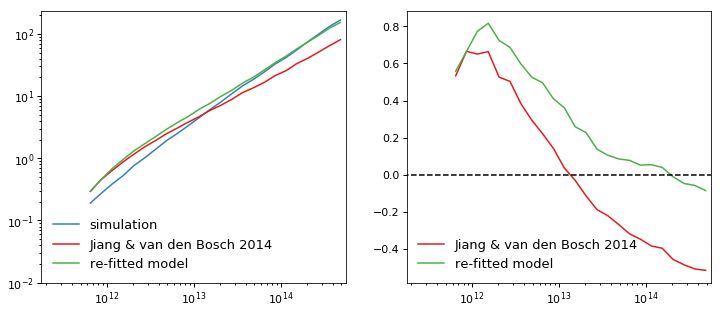

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

mean_occupation_model1 = mean_nsub_prediction(beta_jiang14, zeta_jiang14, 
                                              gamma1_jiang14, alpha1_jiang14, 
                                              gamma2_jiang14, alpha2_jiang14)

mean_occupation_model2 = mean_nsub_prediction(beta_jiang14, zeta_jiang14, 
                                              gamma1_jiang14, -0.925, 
                                              gamma2_jiang14, alpha2_jiang14)

__=ax1.loglog()
__=ax1.plot(bin_mids, mean_occupation_bolshoi, label='simulation', color=blue)
__=ax1.plot(bin_mids, mean_occupation_model1, label='Jiang & van den Bosch 2014', color=red)
__=ax1.plot(bin_mids, mean_occupation_model2, label='re-fitted model', color=green)

xscale2 = ax2.set_xscale('log')
fracdiff1 = (mean_occupation_model1 - mean_occupation_bolshoi)/mean_occupation_bolshoi
fracdiff2 = (mean_occupation_model2 - mean_occupation_bolshoi)/mean_occupation_bolshoi

__=ax2.plot(bin_mids, fracdiff1, label='Jiang & van den Bosch 2014', color=red)
__=ax2.plot(bin_mids, fracdiff2, label='re-fitted model', color=green)
__=ax2.plot(np.logspace(log10_mhost_min-1, log10_mhost_max+1, 100), np.zeros(100), '--', color='k')

xlim2 = ax2.set_xlim(xmin=10**(log10_mhost_min-0.5), xmax=10**log10_mhost_max)
xlim1 = ax1.set_xlim(xmin=10**(log10_mhost_min-0.5), xmax=10**log10_mhost_max)
ylim1 = ax1.set_ylim(ymin=0.01)


legend1 = ax1.legend()
legend2 = ax2.legend()

